In this simple tutorial we will fit a pair-potential to a DFT data-set consisting of 699 bulk structures of NaCl. The strucutres are created by randomly ratteling the atoms inside a 2x2x2 supercell and computing the corresponding atomic forces and enegies using DFT and the PBE functional.

In Ref. https://pubs.acs.org/doi/full/10.1021/acs.jpcc.0c08870 a ML potential was fitted to a similar data-set using DFT and DFT and the PBE functional. Your task is to generate a pair-potenital for NaCl using the CCS approach (https://github.com/Teoroo-CMC/CCS) and compare computed RDF and Diffusion coeffecients.

In [1]:
# Install the ccs-package
!pip install ccs_fit

In [4]:
# Download data from the reference work and the DFT structures on which we perform the fitting
!wget https://raw.githubusercontent.com/jollactic/Modelling_course/main/FF_MD/NaNa.txt
!wget https://raw.githubusercontent.com/jollactic/Modelling_course/main/FF_MD/NaCl.txt
!wget https://raw.githubusercontent.com/jollactic/Modelling_course/main/FF_MD/ClCl.txt
!wget https://raw.githubusercontent.com/jollactic/Modelling_course/main/FF_MD/DFT.db

--2024-04-24 07:48:57--  https://raw.githubusercontent.com/jollactic/Modelling_course/main/FF_MD/NaNa.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2871 (2.8K) [text/plain]
Saving to: ‘NaNa.txt.1’

NaNa.txt.1          100%[===================>]   2.80K  --.-KB/s    in 0s      

2024-04-24 07:48:57 (31.9 MB/s) - ‘NaNa.txt.1’ saved [2871/2871]

--2024-04-24 07:48:57--  https://raw.githubusercontent.com/jollactic/Modelling_course/main/FF_MD/NaCl.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2602 (2.5K) [text/plain]
Saving

In [5]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

ccs_fetch(mode="CCS",DFT_DB="DFT.db",include_forces=True)

    Fetching data: 100%|██████████| 699/699 [00:21<00:00, 32.74it/s]


In [8]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True",
        "do_ridge_regression":"False"
    },
    "Twobody": {
                "Na-Na": {
                        "Rcut": 3.5,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Cl-Cl": {
                        "Rcut": 3.5,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Na-Cl": {
                        "Rcut": 3.5,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [9]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Cl', 'Na']
    Generating two-body potentials from one-body information.
    Adding pair: Cl-Cl
    Adding pair: Cl-Na
    Adding pair: Na-Na
    Applying monotonic constraints for pair:  Cl-Cl
    Applying monotonic constraints for pair:  Cl-Na
    Applying monotonic constraints for pair:  Na-Na
    There is linear dependence in stochiometry matrix!
    Removing onebody term: Na


    Finding optimum switch: 100%|██████████| 1/1 [00:00<00:00, 21.93it/s]

    The best switch is (6, 8, 7) with rmse: 6.952769232471333, corresponding to distances of [3.97 3.94 3.98] Å for element pairs ['Cl-Cl', 'Cl-Na', 'Na-Na'].


# Checking quallity of the fit
Try to modify the setting in the input above to improve the fitting.

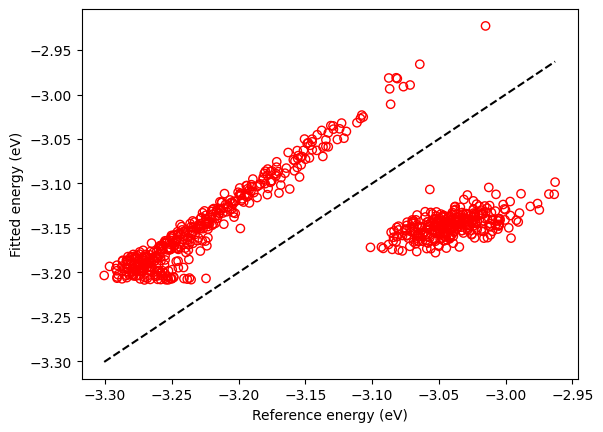

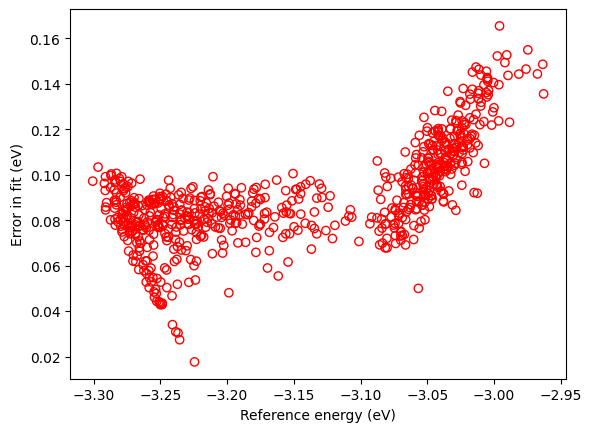

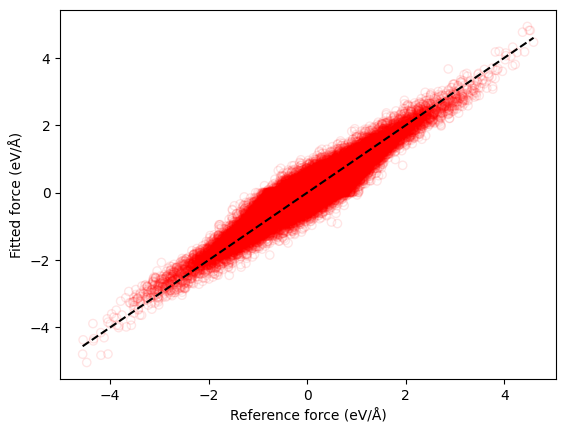

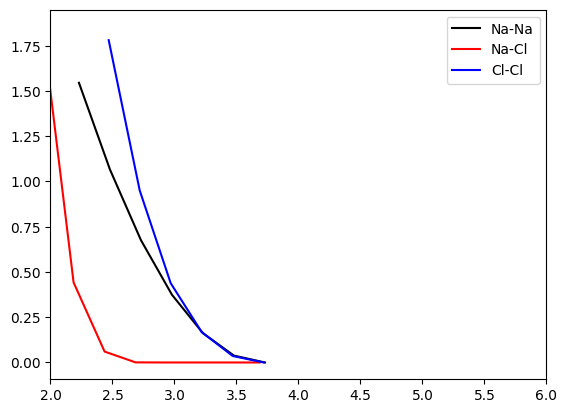

In [12]:

import numpy as np
import json
import matplotlib.pyplot as plt

with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)

with open("structures.json", "r") as f:
    training_set = json.load(f)


err=np.loadtxt("CCS_error.out")

err[:,0]=err[:,0]/err[:,3]
err[:,1]=err[:,1]/err[:,3]
err[:,2]=err[:,2]/err[:,3]

plt.xlabel('Reference energy (eV)')
plt.ylabel('Fitted energy (eV)')
plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
plt.show()
plt.xlabel('Reference energy (eV)')
plt.ylabel('Error in fit (eV)')
plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
plt.show()


err_F=np.loadtxt("CCS_error_forces.out")
plt.xlabel('Reference force (eV/Å)')
plt.ylabel('Fitted force (eV/Å)')
plt.plot( [min(err_F[:,0]),max(err_F[:,0])],[min(err_F[:,0]),max(err_F[:,0])],'--',color='black')
plt.scatter(err_F[:,0],err_F[:,1],facecolors='none', edgecolors='red',alpha=0.1 )
plt.show()

plt.xlim(2,6)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
r=np.array(CCS_params["Two_body"]["Na-Na"]["r"])
NaNa=np.array(CCS_params["Two_body"]["Na-Na"]["spl_a"])
plt.plot(r,NaNa,color='black',label="Na-Na")
r=np.array(CCS_params["Two_body"]["Cl-Na"]["r"])
NaCl=np.array(CCS_params["Two_body"]["Cl-Na"]["spl_a"])
plt.plot(r,NaCl,color='red',label="Na-Cl")
r=np.array(CCS_params["Two_body"]["Cl-Cl"]["r"])
ClCl=np.array(CCS_params["Two_body"]["Cl-Cl"]["spl_a"])
plt.plot(r,ClCl,color='blue',label="Cl-Cl")

plt.legend()
plt.show()

# RUN MD
Molecular dynamics can be runned using ASE. Below is an example. The parameters have not been choosen wisely so will have fix this!

The trajectory is stored in a file `moldyn.traj` that ASE can read and analyse.


In [ ]:
from ase.lattice.cubic import FaceCenteredCubic
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase import units
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
from ase.io.trajectory import Trajectory
from ase.build import bulk
import json


json_file = open("CCS_params.json")
CCS_params = json.load(json_file)


atoms=bulk('NaCl','rocksalt',a=7.0,cubic=True) #Try to match cell volume to reference work. (CHECK THEIR SUPPORTING INFO!)
atoms=atoms*[2,2,2]

calc = CCS(CCS_params=CCS_params)
atoms.calc=calc

print("Initial energy:", atoms.get_potential_energy())

T=1400 # IN KELVIN,  Try to match with the reference work.
time_step = 2 * units.fs # Set a reasonable time-step!


# Initialice velocities corresponding to T
MaxwellBoltzmannDistribution(atoms, temperature_K=T)

# We want to run MD with constant T.
dyn = Langevin(atoms, time_step, T * units.kB, 0.1)


def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))

#Equillibrate
printenergy(atoms)
for i in range(10):
    dyn.run(100)
    printenergy(atoms)

traj = Trajectory('moldyn.traj', 'w', atoms)
dyn.attach(traj.write, interval=100)


# Now run the dynamics
printenergy(atoms)
for i in range(10):
    print("STEP: ", i*100," ",end='')
    dyn.run(100)
    printenergy(atoms)

print("Final energy:", atoms.get_potential_energy())


/usr/local/lib/python3.10/dist-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)
/usr/local/lib/python3.10/dist-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


Initial energy: -205.37434052442748
Energy per atom: Epot = -3.209eV  Ekin = 0.145eV (T=1121K)  Etot = -3.064eV
Energy per atom: Epot = -3.175eV  Ekin = 0.145eV (T=1123K)  Etot = -3.030eV
Energy per atom: Epot = -3.172eV  Ekin = 0.166eV (T=1282K)  Etot = -3.006eV
Energy per atom: Epot = -3.167eV  Ekin = 0.187eV (T=1449K)  Etot = -2.980eV
Energy per atom: Epot = -3.165eV  Ekin = 0.203eV (T=1573K)  Etot = -2.961eV
Energy per atom: Epot = -3.165eV  Ekin = 0.190eV (T=1471K)  Etot = -2.975eV
Energy per atom: Epot = -3.149eV  Ekin = 0.179eV (T=1388K)  Etot = -2.970eV
Energy per atom: Epot = -3.175eV  Ekin = 0.188eV (T=1452K)  Etot = -2.987eV
Energy per atom: Epot = -3.165eV  Ekin = 0.191eV (T=1476K)  Etot = -2.974eV
Energy per atom: Epot = -3.180eV  Ekin = 0.175eV (T=1352K)  Etot = -3.006eV
Energy per atom: Epot = -3.173eV  Ekin = 0.197eV (T=1522K)  Etot = -2.976eV
Energy per atom: Epot = -3.173eV  Ekin = 0.197eV (T=1522K)  Etot = -2.976eV
STEP:  0  Energy per atom: Epot = -3.141eV  Ekin = 0

In [ ]:
# run more MD to get better statistics

for i in range(10):
    print("STEP: ", i*100," ",end='')
    dyn.run(100)
    printenergy(atoms)

# Compare RDF
The RDF from figure S2 in the refence work can be plotted using following set of commands. Try to plot you data along-side with it.

In [ ]:
ref_NaNa=np.loadtxt('NaNa.txt')
ref_NaCl=np.loadtxt('NaCl.txt')
ref_ClCl=np.loadtxt('ClCl.txt')

plt.plot(ref_NaNa[:,0],ref_NaNa[:,1,],'--',label="Ref. Na-Na",color="blue")
plt.plot(ref_NaCl[:,0],ref_NaCl[:,1,],'--',label="Ref. Na-Cl",color="red")
plt.plot(ref_ClCl[:,0],ref_ClCl[:,1,],'--',label="Ref. Cl-Cl",color="green")
plt.legend()

# Compute diffusion coefficient
Try to estimate the diffusion coeffecients for Na and Cl.